<a href="https://colab.research.google.com/github/fractal2k/Twitter-Sentiment-Prediction/blob/master/torch_Twitter_Sentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentiment140 with PyTorch and GloVe Twitter Embeddings

[hiddenlayer](https://github.com/waleedka/hiddenlayer) is a convenient visualization library that we use to visualize our training and testing loss/accuracy.

In [1]:
!pip install hiddenlayer

## Kaggle configuration and Getting the dataset

In [2]:
!mkdir .kaggle

In [3]:
import json

token = {'username': '<your username here>','key':'<your API key here>'}
with open('./.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)

In [ ]:
# Copy the kaggle directory to root
!cp -avr ./.kaggle ~/

In [ ]:
!kaggle config set -n path -v {/content}

In [ ]:
!kaggle datasets download -d kazanova/sentiment140 -p /content

In [7]:
!unzip -qq sentiment140.zip

## Making the necessary imports

In [ ]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sn
from sklearn.model_selection import train_test_split
import hiddenlayer as hl

from collections import defaultdict

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.optimizer import Optimizer

import torchtext
from torchtext import data

## Reading the data and preprocessing

In [9]:
df = pd.read_csv('training.1600000.processed.noemoticon.csv', names=['target', 'ids', 'date', 'flag', 'user', 'text'], encoding='ISO-8859-1')

In [ ]:
df.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [10]:
raw_data = df[['text', 'target']].copy(deep=True)

In [ ]:
raw_data.head()

,text,target
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",0
1,is upset that he can't update his Facebook by ...,0
2,@Kenichan I dived many times for the ball. Man...,0
3,my whole body feels itchy and like its on fire,0
4,"@nationwideclass no, it's not behaving at all....",0


We sub out the usernames with the ```<user>``` tag, links with the ```<url>``` tag, hashtags with the ```<hashtag>``` tag and numbers with the ```<number>``` tag. After that, we filter out all the punctuations.</br>This is necessary because we use the GloVe Twitter Embeddings, which contain these tags.

In [11]:
# Sub the rest of the elements before filtering the punctuations out, otherwise 
# the punctuation regex will get rid of the symbols necessary for these elements
# too
def clean(text):
    USER = '@[\w_]+'
    LINK = 'https?:\/\/\S+'
    HASHTAG = '#\S+'
    NUMBER = '\d+'
    PUNCTUATIONS = '[\.?!,;:\-\[\]\{\}\(\)\'\"/]'

    user_sub = re.sub(USER, ' <user> ', text)
    link_sub = re.sub(LINK, ' <url> ', user_sub)
    hashtag_sub = re.sub(HASHTAG, ' <hashtag> ', link_sub)
    number_sub = re.sub(NUMBER, ' <number> ', hashtag_sub)
    clean_text = re.sub(PUNCTUATIONS, ' ', number_sub)

    return clean_text.lower()

In [12]:
raw_data['text'] = raw_data['text'].apply(lambda x: clean(x))

The target values are {0, 4}, so we replace 4 with 1 instead.

In [13]:
raw_data['target'] = raw_data['target'].replace(4, 1)

In [ ]:
raw_data.head(10)

,text,target
0,<user> <url> awww that s a bummer you...,0
1,is upset that he can t update his facebook by ...,0
2,<user> i dived many times for the ball mana...,0
3,my whole body feels itchy and like its on fire,0
4,<user> no it s not behaving at all i m mad...,0
5,<user> not the whole crew,0
6,need a hug,0
7,<user> hey long time no see yes rains a ...,0
8,<user> nope they didn t have it,0
9,<user> que me muera,0


Splitting into train and test sets:

In [14]:
train, test = train_test_split(raw_data, test_size=0.15)

In [15]:
!mkdir data

In [16]:
train.to_csv('./data/train.csv', index=False)
test.to_csv('./data/test.csv', index=False)

In [17]:
TEXT = data.Field(include_lengths=True)
LABEL = data.LabelField(dtype=torch.float)
fields = [('text', TEXT), ('label', LABEL)]

In [18]:
trainds, testds = data.TabularDataset.splits(path='./data', format='csv', train='train.csv', test='test.csv', fields=fields, skip_header=True)

In [19]:
TEXT.build_vocab(trainds, max_size=2000000, vectors='glove.twitter.27B.50d', unk_init=torch.normal)

.vector_cache/glove.twitter.27B.zip: 1.52GB [12:19, 2.06MB/s]                            
100%|█████████▉| 1190835/1193514 [00:41<00:00, 28541.10it/s]

In [20]:
LABEL.build_vocab(trainds)

In [21]:
LABEL.vocab.stoi['0'] = 0
LABEL.vocab.stoi['1'] = 1
LABEL.vocab.stoi

defaultdict(<function torchtext.vocab._default_unk_index>, {'0': 0, '1': 1})

In [22]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
BATCH_SIZE = 1024

train_iterator, test_iterator = data.BucketIterator.splits(datasets=(trainds, testds), 
                                                           batch_sizes=(BATCH_SIZE, BATCH_SIZE), 
                                                           sort_key=lambda x: len(x.text), 
                                                           sort_within_batch=True, 
                                                           device=device)

## Here comes the model

Lookahead optimizer implementation from [Michael Zhang's Github repo](https://github.com/michaelrzhang/lookahead/blob/master/lookahead_pytorch.py).

In [24]:
class Lookahead(Optimizer):
    r"""PyTorch implementation of the lookahead wrapper.
    Lookahead Optimizer: https://arxiv.org/abs/1907.08610
    """

    def __init__(self, optimizer, la_steps=5, la_alpha=0.8, pullback_momentum="none"):
        """optimizer: inner optimizer
        la_steps (int): number of lookahead steps
        la_alpha (float): linear interpolation factor. 1.0 recovers the inner optimizer.
        pullback_momentum (str): change to inner optimizer momentum on interpolation update
        """
        self.optimizer = optimizer
        self._la_step = 0  # counter for inner optimizer
        self.la_alpha = la_alpha
        self._total_la_steps = la_steps
        pullback_momentum = pullback_momentum.lower()
        assert pullback_momentum in ["reset", "pullback", "none"]
        self.pullback_momentum = pullback_momentum

        self.state = defaultdict(dict)

        # Cache the current optimizer parameters
        for group in optimizer.param_groups:
            for p in group['params']:
                param_state = self.state[p]
                param_state['cached_params'] = torch.zeros_like(p.data)
                param_state['cached_params'].copy_(p.data)
                if self.pullback_momentum == "pullback":
                    param_state['cached_mom'] = torch.zeros_like(p.data)

    def __getstate__(self):
        return {
            'state': self.state,
            'optimizer': self.optimizer,
            'la_alpha': self.la_alpha,
            '_la_step': self._la_step,
            '_total_la_steps': self._total_la_steps,
            'pullback_momentum': self.pullback_momentum
        }

    def zero_grad(self):
        self.optimizer.zero_grad()

    def get_la_step(self):
        return self._la_step

    def state_dict(self):
        return self.optimizer.state_dict()

    def load_state_dict(self, state_dict):
        self.optimizer.load_state_dict(state_dict)

    def _backup_and_load_cache(self):
        """Useful for performing evaluation on the slow weights (which typically generalize better)
        """
        for group in self.optimizer.param_groups:
            for p in group['params']:
                param_state = self.state[p]
                param_state['backup_params'] = torch.zeros_like(p.data)
                param_state['backup_params'].copy_(p.data)
                p.data.copy_(param_state['cached_params'])

    def _clear_and_load_backup(self):
        for group in self.optimizer.param_groups:
            for p in group['params']:
                param_state = self.state[p]
                p.data.copy_(param_state['backup_params'])
                del param_state['backup_params']

    @property
    def param_groups(self):
        return self.optimizer.param_groups

    def step(self, closure=None):
        """Performs a single Lookahead optimization step.
        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = self.optimizer.step(closure)
        self._la_step += 1

        if self._la_step >= self._total_la_steps:
            self._la_step = 0
            # Lookahead and cache the current optimizer parameters
            for group in self.optimizer.param_groups:
                for p in group['params']:
                    param_state = self.state[p]
                    p.data.mul_(self.la_alpha).add_(1.0 - self.la_alpha, param_state['cached_params'])  # crucial line
                    param_state['cached_params'].copy_(p.data)
                    if self.pullback_momentum == "pullback":
                        internal_momentum = self.optimizer.state[p]["momentum_buffer"]
                        self.optimizer.state[p]["momentum_buffer"] = internal_momentum.mul_(self.la_alpha).add_(
                            1.0 - self.la_alpha, param_state["cached_mom"])
                        param_state["cached_mom"] = self.optimizer.state[p]["momentum_buffer"]
                    elif self.pullback_momentum == "reset":
                        self.optimizer.state[p]["momentum_buffer"] = torch.zeros_like(p.data)

        return loss

Now, we define the model architecture:

In [30]:
class TwitterSentimentPredictor(nn.Module):
    def __init__(self, vocab_size, embedding_dim, pretrained_embeddings, hidden_dim, output_dim, n_layers, pad_idx, bidirectional):
        super(TwitterSentimentPredictor, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        self.embedding.weight.data.copy_(pretrained_embeddings)  # Initialize embeddings
        # We don't freeze the embedding layer because I've found that to give better training accuracy

        # Define LSTM Layers
        self.lstm = nn.LSTM(input_size=embedding_dim, hidden_size=hidden_dim, num_layers=n_layers, dropout=0.8, bidirectional=bidirectional)

        # Final dense
        self.dropout = nn.Dropout(0.8)
        self.dense1 = nn.Linear(hidden_dim * 2, output_dim)
    

    def forward(self, input, lengths):

        embed = self.embedding(input)

        # Pack sequence
        packed_embed = nn.utils.rnn.pack_padded_sequence(embed, lengths)
        packed_output, (hidden, cell) = self.lstm(packed_embed)

        # Take the hidden state of the last layer for output
        hidden = self.dropout(torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1))
        out = self.dense1(hidden)

        return out

In [31]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = len(TEXT.vocab.vectors[0])
PRETRAINED_EMBEDDINGS = TEXT.vocab.vectors
HIDDEN_DIM = 256
OUTPUT_DIM = 1
N_LAYERS = 2
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]
BIDIRECTIONAL = True

model = TwitterSentimentPredictor(INPUT_DIM, EMBEDDING_DIM, PRETRAINED_EMBEDDINGS, HIDDEN_DIM, OUTPUT_DIM, N_LAYERS, PAD_IDX, BIDIRECTIONAL).to(device)

In [27]:
def calculate_accuracy(output, labels):
    preds = torch.round(torch.sigmoid(output))
    correct = (preds == labels).float()
    acc = correct.sum() / len(correct)
    return acc

In [32]:
# Define loss criterion
criterion = nn.BCEWithLogitsLoss()

# Define optimizer
opt = optim.Adam(model.parameters())
opt = Lookahead(optimizer=opt, la_steps=10)

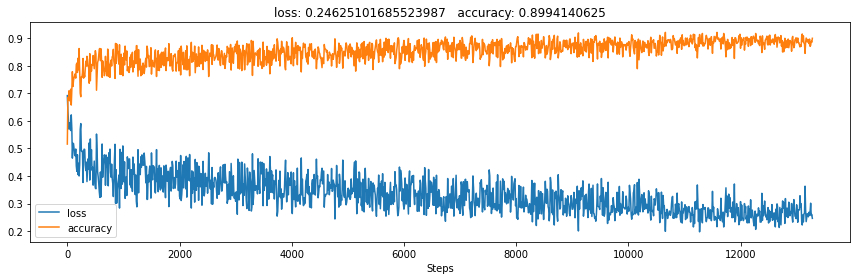

RIP Computer lol


In [33]:
history = hl.History()
canvas = hl.Canvas()
EPOCHS = 10
iters = 0

model.train()
# Training loop
for epoch in range(EPOCHS):
    # Iterate over all the batches
    for batch in train_iterator:
        # Reset gradients
        opt.zero_grad()

        # Get the data and lengths from the batch
        data, data_lengths = batch.text

        # Calculate loss and accuracy
        outputs = model(data, data_lengths).squeeze()

        loss = criterion(outputs, batch.label)
        accuracy = calculate_accuracy(outputs, batch.label)

        # Backpropagate the loss
        loss.backward()

        # Update model parameters
        opt.step()

        # Update loss plot every 10th batch
        if iters % 10 == 0:
            history.log(iters, loss=loss, accuracy=accuracy)
            canvas.draw_plot([history['loss'], history['accuracy']])
        iters +=1

print('RIP Computer lol')

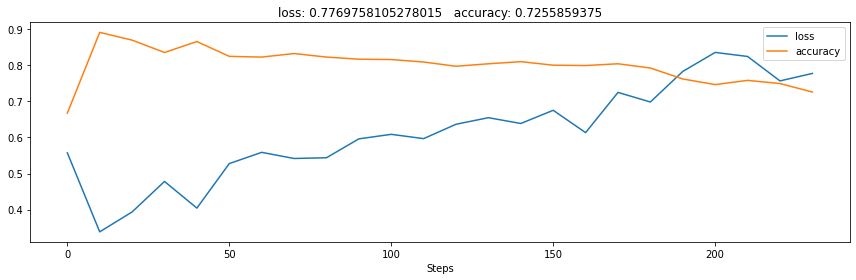

Average accuracy: 0.8081352710723877


In [34]:
test_hist = hl.History()
test_graph = hl.Canvas()
test_iters = 0
preds = np.array([])
labels = np.array([])
acc = []

model.eval()
with torch.no_grad():
    for batch in test_iterator:
        data, data_lengths = batch.text

        opt._backup_and_load_cache()
        outputs = model(data, data_lengths).squeeze()
        preds = np.append(preds, torch.round(torch.sigmoid(outputs)).detach().cpu().numpy())
        labels = np.append(labels, batch.label.detach().cpu().numpy())
        loss = criterion(outputs, batch.label)
        accuracy = calculate_accuracy(outputs, batch.label)
        opt._clear_and_load_backup()
        acc.append(accuracy)

        if test_iters % 10 == 0:
            test_hist.log(test_iters, loss=loss, accuracy=accuracy)
            test_graph.draw_plot([test_hist['loss'], test_hist['accuracy']])
        test_iters += 1
print(f'Average accuracy: {sum(acc) / len(acc)}')

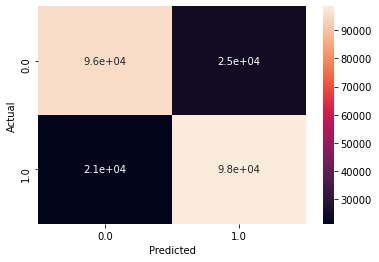

In [35]:
cm_data = {'preds': preds, 'true': labels}
cm_df = pd.DataFrame.from_dict(cm_data)
cm = pd.crosstab(cm_df['true'], cm_df['preds'], rownames=['Actual'], colnames=['Predicted'])

sn.heatmap(cm, annot=True)
plt.show()

In [57]:
def predict(text):
    clean_text = clean(text)
    tokenized = [word for word in clean_text.split(' ') if word != '']
    indexed = [TEXT.vocab.stoi[w] for w in tokenized]
    length = [len(indexed)]
    tensor = torch.LongTensor(indexed).to(device)
    tensor = tensor.unsqueeze(1)
    length_tensor = torch.LongTensor(length)
    prediction = torch.sigmoid(model(tensor, length_tensor))
    return prediction.item()

In [58]:
predict("i hate you")

0.05238809064030647

In [59]:
predict("took my dog out for a walk, the weather was pretty good")

0.905511200428009

In [36]:
import pickle

torch.save(model.state_dict(), './twitter_sentiment_state_dict.pt')

model_config = {'stoi' : TEXT.vocab.stoi,
        'input_dim': INPUT_DIM,
        'hidden_dim': HIDDEN_DIM,
        'embedding_dim': EMBEDDING_DIM,
        'output_dim': OUTPUT_DIM,
        'n_layers': N_LAYERS,
        'pad_idx': PAD_IDX}

with open('config.pickle', 'wb') as handle:
    pickle.dump(model_config, handle, protocol=pickle.HIGHEST_PROTOCOL)